### Global

#### Librairies

In [98]:
import os
import json
import numpy as np
import torch
import torchaudio
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sns

#### Variables

In [99]:
#path_drive = "/content/drive/MyDrive/projet_signal/"
path_drive = "./"
path_data = path_drive + "data/"
path_music = path_data + "music/"

themes = ["classic", "techno", "rap", 'metal']

#### Fonctions utilitaires

In [100]:
def throw_error(text):
  print("Error: " + text)

def throw_info(text):
  print("Info: " + text)

current_file_name = ""
def create_score_file(lr, maxEpoch, fftlength, dataset_length):
  i = 0
  while os.path.exists("./scores/score" + str(i) + ".txt"):
    i += 1

  global current_file_name
  current_file_name = "./scores/score" + str(i) + ".txt"
  file = open(current_file_name, "w")
  file.close()
  file = open(current_file_name, "r+")
  text = f"Training data : lr: {lr}, maxEpoch: {maxEpoch}, fftLength: {fftlength}, dataset_length: {dataset_length}\n[\n[\n"
  file.write(text)
  file.close()

def write_training_data(loss, test_accuracy):
  file = open(current_file_name, 'r')
  lines = file.readlines()
  file.close()
  file = open(current_file_name, 'w')
  lines[1] = lines[1][0:-1]
  lines[1] += str(loss) + ","
  lines[2] = lines[2][0:-1]
  lines[2] += str(test_accuracy) + ","
  text = lines[0] + lines[1] + "\n" + lines[2] + "\n"
  file.write(text)
  file.close()


### Dataset

#### Hyperparamètre du dataset et de l'apprentisage

In [101]:
#training params
learningRate = 0.001
batchSize = 10
epochs = 30
input_length = 10000
dataset_length = 5000
hop_length = 200
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device : " + device)

Device : cuda


### Chargement du dataset

In [102]:
spectrograms = []
labels = []

def compute_spectrogram(waveform, n_fft, hop_length):
    window = torch.hann_window(n_fft)
    waveform = waveform * window

    specgram = torch.stft(waveform, n_fft=n_fft, hop_length=hop_length, window=window, center=False, return_complex=True)

    magnitude_specgram = torch.sqrt(specgram.pow(2).sum(-1))

    return magnitude_specgram

def create_dataset(spectrograms, labels):
  for i in range(0, dataset_length):
    randIndex = torch.randint(0, len(themes), (1,))[0]
    theme = themes[randIndex]
    files_path = "./data/" + theme
    musics = os.listdir(files_path)
    files_path = files_path + '/'
    music = musics[torch.randint(0, len(musics), (1,))[0]]
    throw_info(f"{(float(i) / float(dataset_length)) * 100.0}% of the dataset created")

    waveform, sample_rate = torchaudio.load(files_path + music)
    #convert into mono
    waveform = 0.5 * (waveform[0] + waveform[1])
    randIndex = torch.randint(0, waveform.shape[0] - (2 * input_length), (1,))[0]
    waveform = waveform[randIndex : randIndex + (2 * input_length)]
    
    #fft = torch.fft.fft(waveform)
    spectrogramm = compute_spectrogram(waveform, 2 * input_length, hop_length)[0:input_length]
    spectrograms.append(spectrogramm)
    labels.append(themes.index(theme))

  # Convert lists to tensors
  labels = torch.tensor(labels)

create_dataset(spectrograms, labels)


Info: 0.0% of the dataset created
Info: 0.02% of the dataset created
Info: 0.04% of the dataset created
Info: 0.06% of the dataset created
Info: 0.08% of the dataset created
Info: 0.1% of the dataset created
Info: 0.12% of the dataset created
Info: 0.13999999999999999% of the dataset created
Info: 0.16% of the dataset created
Info: 0.18% of the dataset created
Info: 0.2% of the dataset created
Info: 0.22% of the dataset created
Info: 0.24% of the dataset created
Info: 0.26% of the dataset created
Info: 0.27999999999999997% of the dataset created
Info: 0.3% of the dataset created
Info: 0.32% of the dataset created
Info: 0.33999999999999997% of the dataset created
Info: 0.36% of the dataset created
Info: 0.38% of the dataset created
Info: 0.4% of the dataset created
Info: 0.42% of the dataset created
Info: 0.44% of the dataset created
Info: 0.45999999999999996% of the dataset created
Info: 0.48% of the dataset created
Info: 0.5% of the dataset created
Info: 0.52% of the dataset created
I

### Entraînement perceptron multicouche

In [103]:
import torch
import torch.nn.functional as F

class MusicGenreCNN(nn.Module):
    def __init__(self):
        super(MusicGenreCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=10)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=1, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        #(1000 : 123 |5000 : 623 | 10000 : 1248 | 25000 : 3123 | 30000 : 3748 | 40000 : 4998 | 50000 : 6248)
        self.fc1 = nn.Linear(1248, 256)
        self.fc2 = nn.Linear(256, len(themes))

    def forward(self, x):
        # Input shape: (batch_size, channels, sequence_length)
        #print("Step1 : " + str(x.shape))
        x = self.conv1(x)
        #print("Step2 : " + str(x.shape))
        x = F.relu(x)
        #print("Step3 : " + str(x.shape))
        x = self.pool(x)
        #print("Step4 : " + str(x.shape))
        x = self.conv2(x)
        #print("Step5 : " + str(x.shape))
        x = F.relu(x)
        #print("Step6 : " + str(x.shape))
        x = self.pool(x)
        #print("Step7 : " + str(x.shape))
        x = self.conv3(x)
        #print("Step8 : " + str(x.shape))
        x = F.relu(x)
        #print("Step9 : " + str(x.shape))
        x = self.pool(x)
        #print("Step10 : " + str(x.shape))
        x = self.conv4(x)
        #print("Step11 : " + str(x.shape))
        x = self.fc1(x)
        #print("Step12 : " + str(x.shape))
        x = F.relu(x)
        #print("Step13 : " + str(x.shape))
        x = self.fc2(x)
        #print("final : " + str(x.shape))
        return x.squeeze(1)

## Fonction utilitaire

In [104]:
def plot_confusion_matrix_from_cm(cm, class_names):
    # Adapted from scikit-learn documentation
    sns.set()
    plt.figure(figsize=(len(class_names), len(class_names)))
    ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix')
    plt.show()

def plot_confusion_matrix(model, data_loader, class_names):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            all_labels.extend(labels.to('cpu').numpy())
            all_predictions.extend(predictions.to('cpu').numpy())

    cm = confusion_matrix(all_labels, all_predictions)
    plot_confusion_matrix_from_cm(cm, class_names)

In [105]:
print(spectrograms[0])

tensor([8.2117e+00+0.0000e+00j, 6.6338e+00+1.7595e+00j, 4.7770e+00+2.7278e+00j,
         ..., 8.6784e-05-1.4877e-04j, 3.7909e-05-1.4198e-04j,
        5.9605e-06+7.7307e-05j])


## Entrainement du CNN

Epoch 1, Loss: 0.783134937286377, accuracy: 0.731


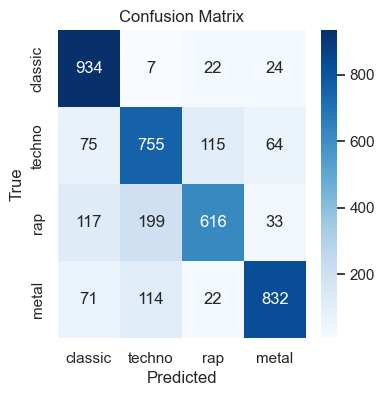

Epoch 2, Loss: 0.5641193389892578, accuracy: 0.728


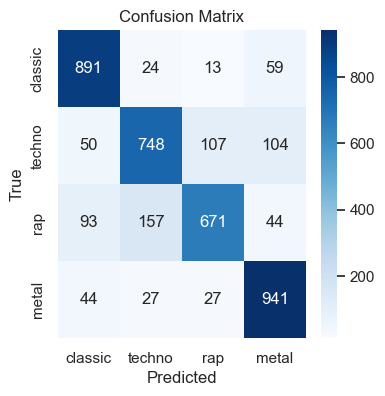

Epoch 3, Loss: 0.5226346850395203, accuracy: 0.757


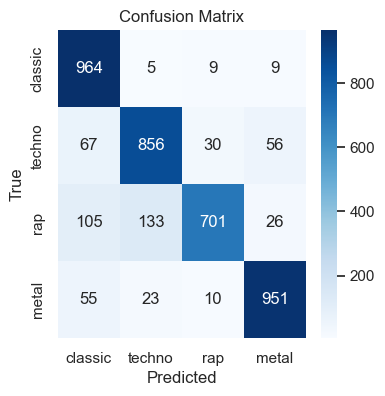

Epoch 4, Loss: 0.5501182079315186, accuracy: 0.74


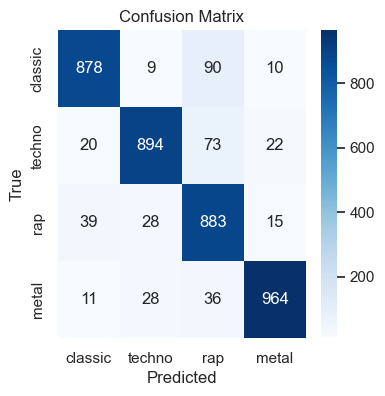

Epoch 5, Loss: 0.4225170612335205, accuracy: 0.763


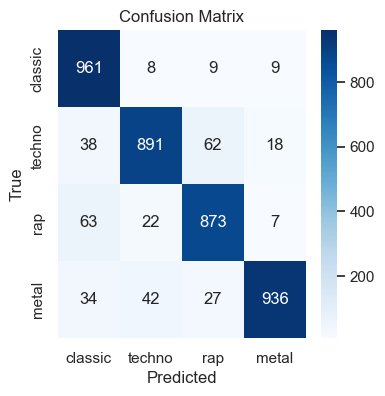

Epoch 6, Loss: 0.3295079469680786, accuracy: 0.78


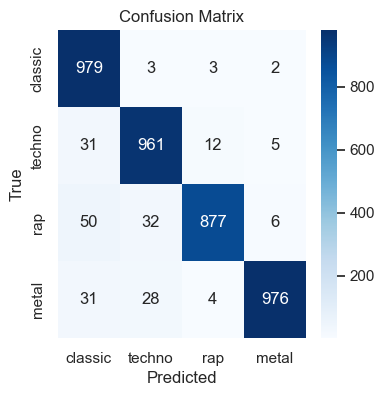

Epoch 7, Loss: 0.029554059728980064, accuracy: 0.773


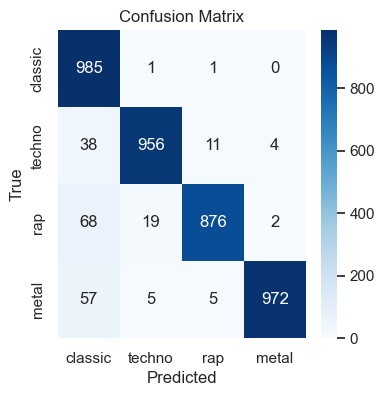

Epoch 8, Loss: 0.16419048607349396, accuracy: 0.763


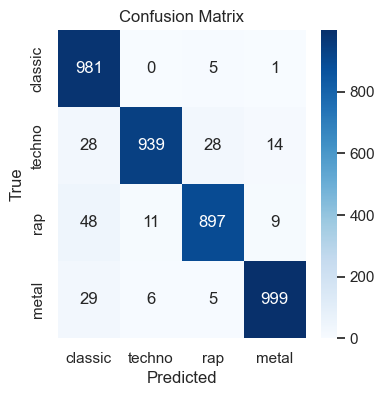

Epoch 9, Loss: 0.4479197561740875, accuracy: 0.767


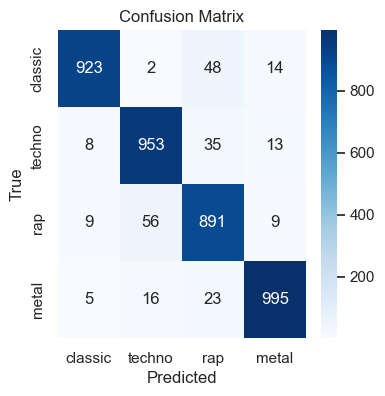

Epoch 10, Loss: 0.21101543307304382, accuracy: 0.781


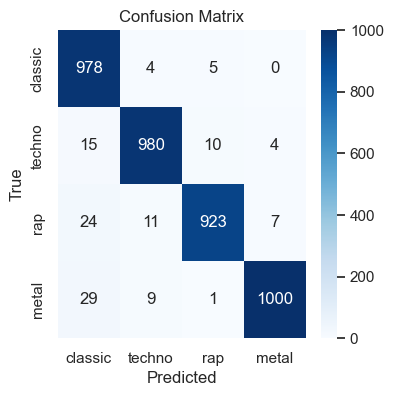

Epoch 11, Loss: 0.19477352499961853, accuracy: 0.764


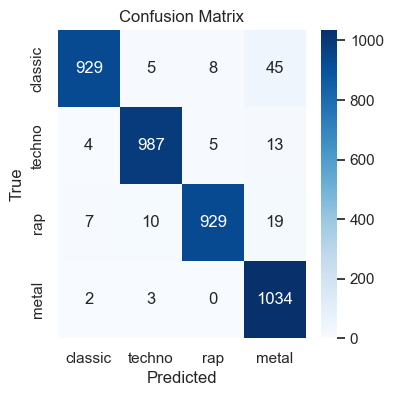

Epoch 12, Loss: 0.038647133857011795, accuracy: 0.781


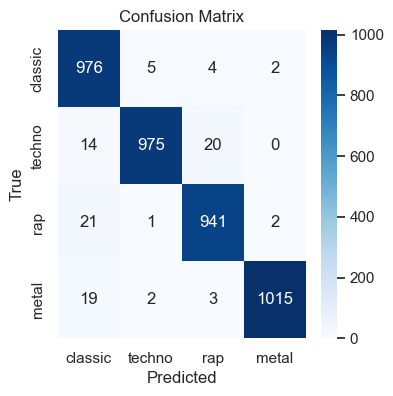

Epoch 13, Loss: 0.1303662657737732, accuracy: 0.778


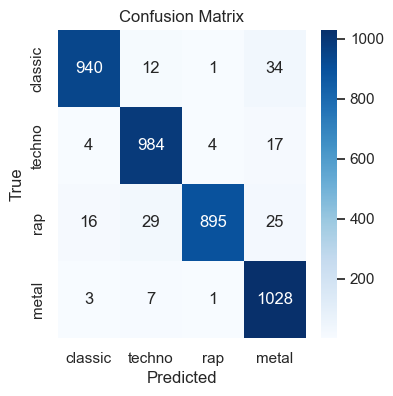

Epoch 14, Loss: 0.2138470858335495, accuracy: 0.77


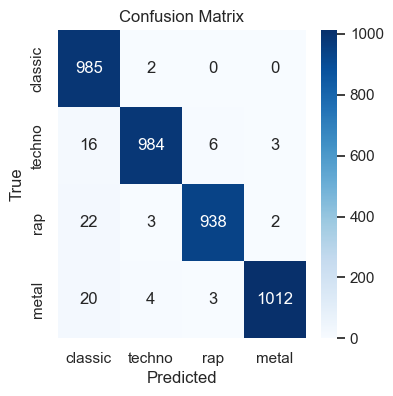

Epoch 15, Loss: 5.6512566516175866e-05, accuracy: 0.76


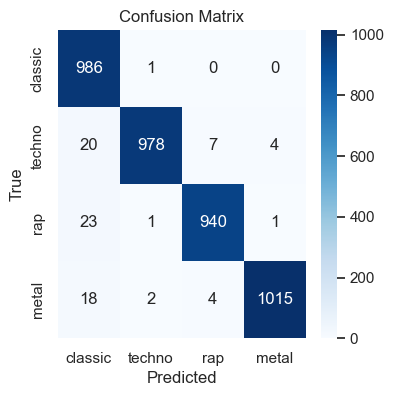

Epoch 16, Loss: 0.007266823202371597, accuracy: 0.785


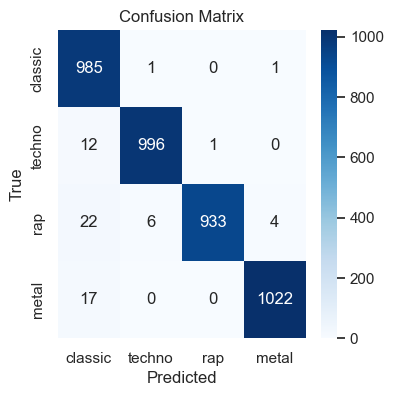

Epoch 17, Loss: 0.1290813386440277, accuracy: 0.774


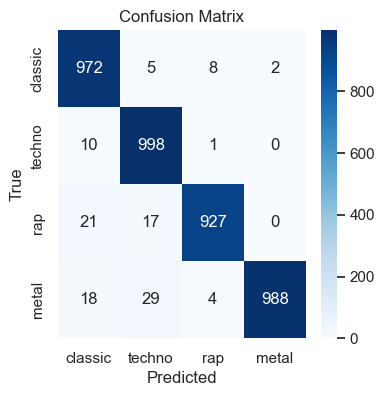

Epoch 18, Loss: 0.06777457892894745, accuracy: 0.788


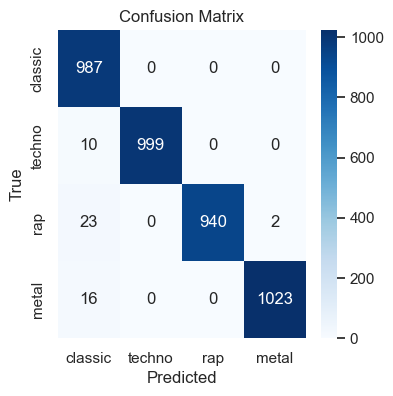

Epoch 19, Loss: 0.0016535440227016807, accuracy: 0.786


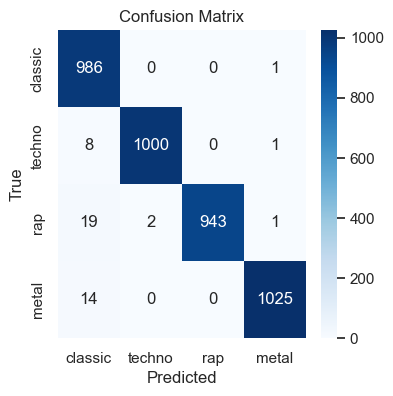

Epoch 20, Loss: 0.002561903093010187, accuracy: 0.79


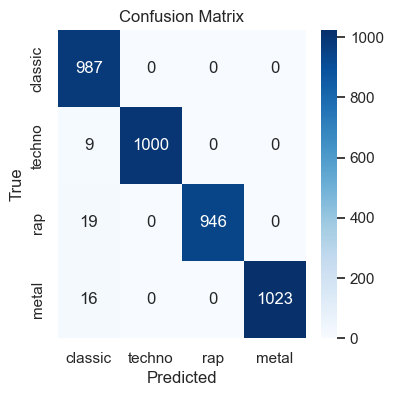

Epoch 21, Loss: 0.0010429427493363619, accuracy: 0.79


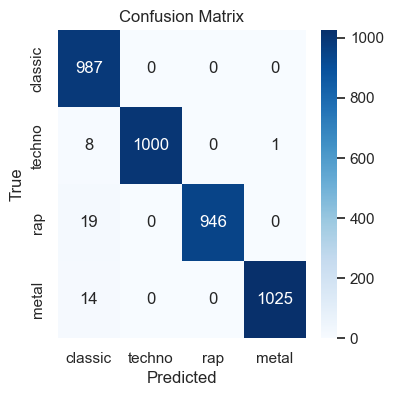

Epoch 22, Loss: 9.536715879221447e-07, accuracy: 0.788


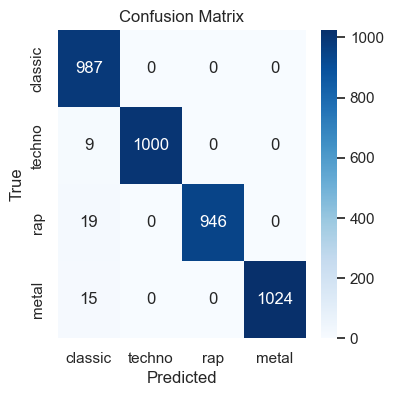

Epoch 23, Loss: 0.3364345133304596, accuracy: 0.76


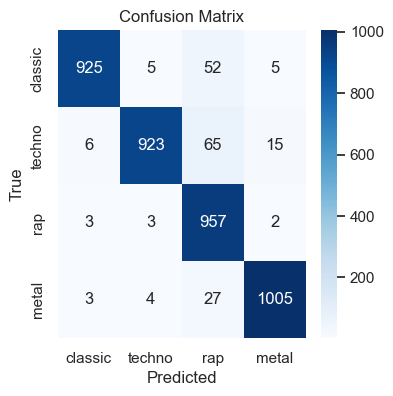

Epoch 24, Loss: 0.03951774165034294, accuracy: 0.768


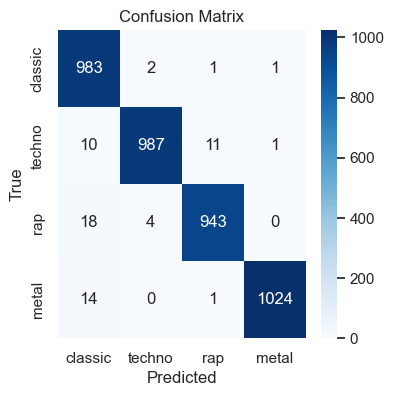

Epoch 25, Loss: 0.04008886590600014, accuracy: 0.791


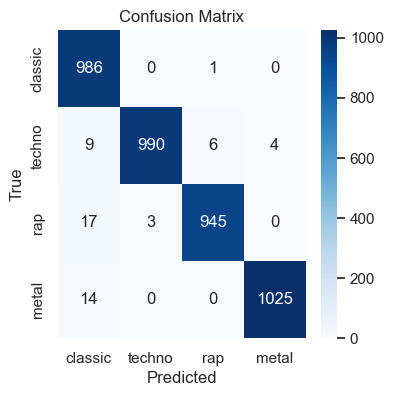

Epoch 26, Loss: 0.4087931513786316, accuracy: 0.743


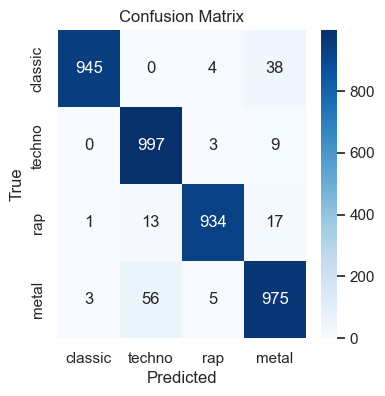

Epoch 27, Loss: 0.001441325293853879, accuracy: 0.783


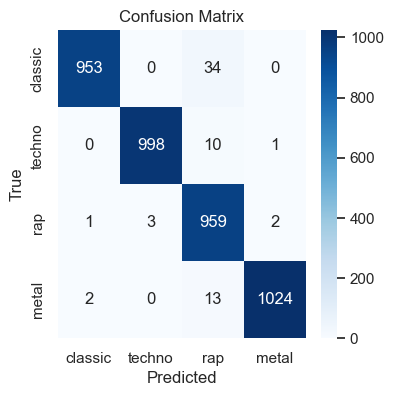

Epoch 28, Loss: 1.0003687143325806, accuracy: 0.738


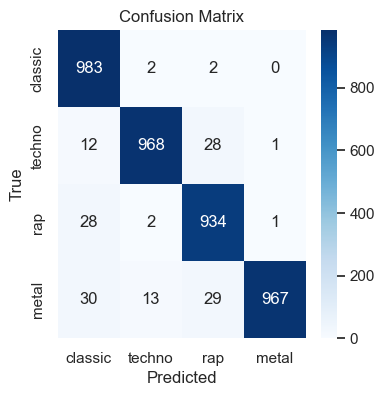

Epoch 29, Loss: 0.0319342203438282, accuracy: 0.779


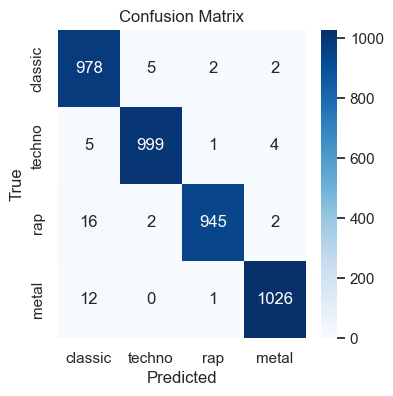

Epoch 30, Loss: 0.004120380152016878, accuracy: 0.787


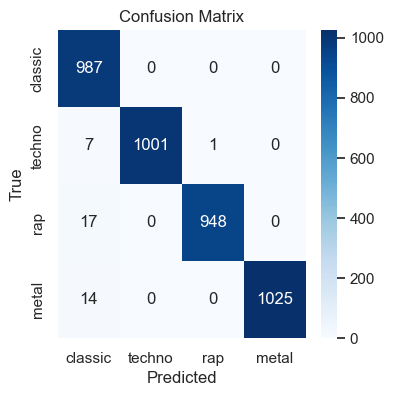

In [106]:
inputs_train, inputs_test, labels_train, labels_test = train_test_split(spectrograms, labels, test_size = 0.2, random_state=145)

model = MusicGenreCNN()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learningRate)

inputs_train = torch.stack(inputs_train).unsqueeze(1).float().to(device)
labels_train = torch.tensor(labels_train, dtype=torch.long).to(device)

inputs_test = torch.stack(inputs_test).unsqueeze(1).float().to(device)
labels_test = torch.tensor(labels_test, dtype=torch.long).to(device)

train_dataset = TensorDataset(inputs_train, labels_train)
train_loader = DataLoader(train_dataset, batch_size = batchSize, shuffle=True)

create_score_file(learningRate, epochs, input_length, dataset_length)

for epoch in range(0, epochs):
    for inputs_batch, labels_batch in train_loader:
        optimizer.zero_grad()
        outputs_batch = model(inputs_batch)
        loss = criterion(outputs_batch, labels_batch)
        loss.backward()
        optimizer.step()

    #test
    outputs_test = model(inputs_test)
    _, predicted = torch.max(outputs_test, 1)
    correct = (predicted == labels_test).sum().item()
    accuracy = correct / labels_test.size(0)
    write_training_data(loss.item(), accuracy)
    print(f"Epoch {epoch+1}, Loss: {loss.item()}, accuracy: {accuracy}")
    plot_confusion_matrix(model, train_loader, themes)

### Tests

Accuracy of the network on test inputs: 78.7%


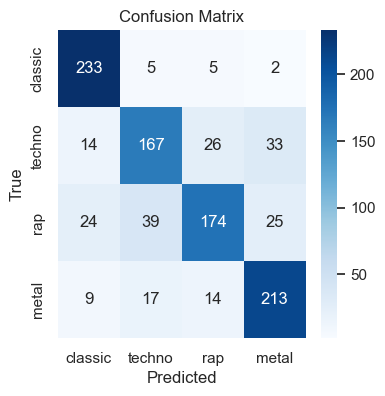

In [107]:
outputs_test = model(inputs_test)
_, predicted = torch.max(outputs_test, 1)
correct = (predicted == labels_test).sum().item()
accuracy = correct / labels_test.size(0)
print(f'Accuracy of the network on test inputs: {accuracy * 100}%')

test_dataset = TensorDataset(inputs_test, labels_test)
test_loader = DataLoader(test_dataset, batch_size = batchSize, shuffle=True)
plot_confusion_matrix(model, test_loader, themes)

Fixing some values : maxEpoch: 50, fftLength: 1000, dataset_length: 1000


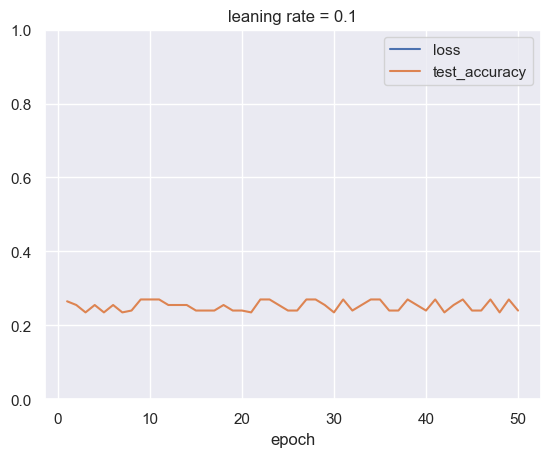

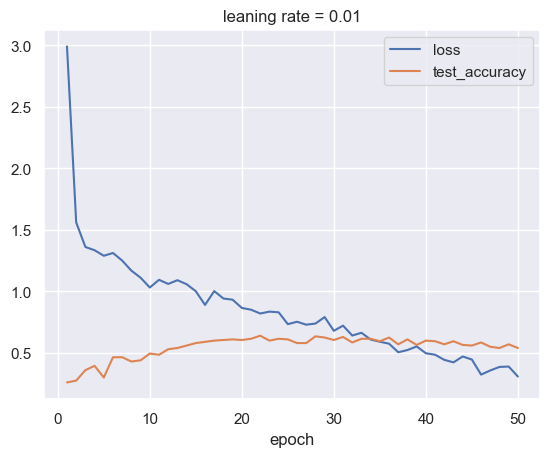

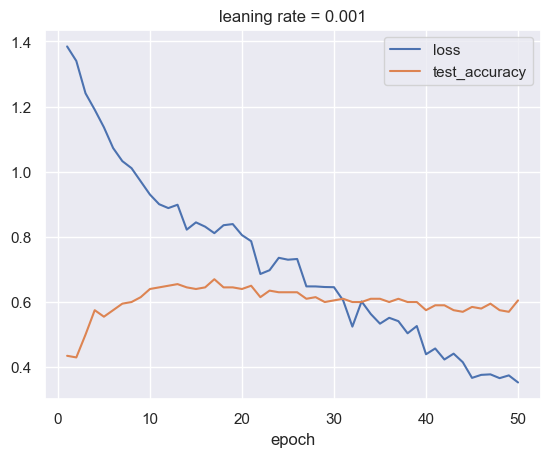

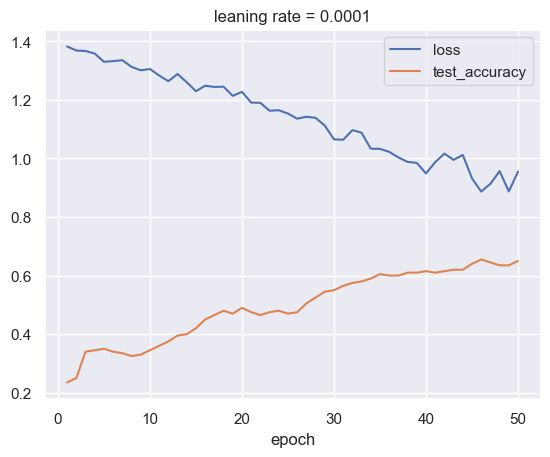

In [108]:
#Plot
def plot(title, loss, accuracy, yMin = None, yMax = None):
    plt.title(title)
    plt.xlabel("epoch")
    Y = np.array(range(1, len(loss) + 1))
    if(yMin != None and yMax != None):
        plt.ylim(yMin, yMax)
    plt.plot(Y, loss, label='loss')
    plt.plot(Y, accuracy, label='test_accuracy')
    plt.legend()
    plt.show()

#Discusing learningRate values
print("Fixing some values : maxEpoch: 50, fftLength: 1000, dataset_length: 1000")

loss = [7941.46435546875,36.484169006347656,24.407928466796875,2389.935302734375,297.948486328125,174.33680725097656,66.11900329589844,14.54992389678955,13.865605354309082,15.229598045349121,7.09071683883667,3.299020528793335,3.755951404571533,3.0146214962005615,2.184262275695801,1.5115859508514404,2.5247228145599365,5.0291290283203125,5.670081615447998,5.203123092651367,3.3034777641296387,1.5878639221191406,3.979611873626709,1.9322737455368042,3.1652653217315674,2.9765100479125977,2.006908416748047,2.5540409088134766,1.9574012756347656,2.2692530155181885,1.681741714477539,1.9987949132919312,1.5479142665863037,1.7721850872039795,1.7053486108779907,1.4525295495986938,1.6249338388442993,1.502156138420105,1.439581274986267,1.4565011262893677,1.4538227319717407,1.420982003211975,1.4497586488723755,1.4341025352478027,1.407806396484375,1.4208301305770874,1.4192397594451904,1.4145766496658325,1.384250283241272,1.4007542133331299]
accuracy = [0.265,0.255,0.235,0.255,0.235,0.255,0.235,0.24,0.27,0.27,0.27,0.255,0.255,0.255,0.24,0.24,0.24,0.255,0.24,0.24,0.235,0.27,0.27,0.255,0.24,0.24,0.27,0.27,0.255,0.235,0.27,0.24,0.255,0.27,0.27,0.24,0.24,0.27,0.255,0.24,0.27,0.235,0.255,0.27,0.24,0.24,0.27,0.235,0.27,0.24]
plot("leaning rate = 0.1", loss, accuracy, 0, 1)

loss = [2.9910757541656494,1.5607949495315552,1.361271619796753,1.334587812423706,1.289703607559204,1.3122367858886719,1.2504650354385376,1.168577790260315,1.1112020015716553,1.0316622257232666,1.0941405296325684,1.0607647895812988,1.0910781621932983,1.0583795309066772,1.0013439655303955,0.8901833891868591,1.0023705959320068,0.9420888423919678,0.9326826930046082,0.8656204342842102,0.8513935804367065,0.8203903436660767,0.8355910181999207,0.8301625847816467,0.7338549494743347,0.7533208131790161,0.7295143604278564,0.7387179732322693,0.791495144367218,0.6797775030136108,0.7218226790428162,0.641263484954834,0.663770318031311,0.6085852980613708,0.5908711552619934,0.5749426484107971,0.5055571794509888,0.5233730673789978,0.5526567697525024,0.4972434937953949,0.4854618310928345,0.44355839490890503,0.42332378029823303,0.471054345369339,0.44615229964256287,0.3235982060432434,0.3577525019645691,0.3861064016819,0.3894105851650238,0.307933509349823]
accuracy = [0.26,0.275,0.36,0.395,0.3,0.465,0.465,0.43,0.44,0.495,0.485,0.53,0.54,0.56,0.58,0.59,0.6,0.605,0.61,0.605,0.615,0.64,0.6,0.615,0.61,0.58,0.58,0.635,0.625,0.605,0.63,0.585,0.615,0.615,0.595,0.625,0.57,0.61,0.565,0.6,0.595,0.57,0.595,0.565,0.56,0.585,0.55,0.54,0.57,0.54]
plot("leaning rate = 0.01", loss, accuracy)

loss = [1.3843879699707031,1.3398693799972534,1.2406173944473267,1.1902589797973633,1.1362030506134033,1.0725858211517334,1.032447338104248,1.0108180046081543,0.9702868461608887,0.9298993945121765,0.9002367258071899,0.888303816318512,0.8985726833343506,0.8221815824508667,0.8444664478302002,0.8312641978263855,0.8113842010498047,0.8357385993003845,0.8392215371131897,0.8054294586181641,0.7866989374160767,0.6860803365707397,0.6976655721664429,0.735742449760437,0.7299189567565918,0.7321369647979736,0.6480115652084351,0.6478806138038635,0.6460798382759094,0.6455234885215759,0.6047102212905884,0.5245914459228516,0.6018110513687134,0.5632376670837402,0.5335857272148132,0.5516167879104614,0.5412608981132507,0.5040242075920105,0.5262741446495056,0.4396910071372986,0.45744404196739197,0.42364704608917236,0.44157734513282776,0.41532057523727417,0.3672420382499695,0.37646588683128357,0.3780408203601837,0.36640647053718567,0.3748534321784973,0.35320132970809937]
accuracy = [0.435,0.43,0.5,0.575,0.555,0.575,0.595,0.6,0.615,0.64,0.645,0.65,0.655,0.645,0.64,0.645,0.67,0.645,0.645,0.64,0.65,0.615,0.635,0.63,0.63,0.63,0.61,0.615,0.6,0.605,0.61,0.6,0.6,0.61,0.61,0.6,0.61,0.6,0.6,0.575,0.59,0.59,0.575,0.57,0.585,0.58,0.595,0.575,0.57,0.605]
plot("leaning rate = 0.001", loss, accuracy)

loss = [1.3826028108596802,1.3686665296554565,1.3671317100524902,1.358384370803833,1.3302243947982788,1.3324525356292725,1.3357206583023071,1.3127979040145874,1.30119788646698,1.3056187629699707,1.2833343744277954,1.263978362083435,1.2886061668395996,1.2602688074111938,1.229625940322876,1.2484222650527954,1.2443331480026245,1.2452412843704224,1.2137322425842285,1.2276533842086792,1.1909428834915161,1.1899739503860474,1.163027286529541,1.1647858619689941,1.1533945798873901,1.1360102891921997,1.1424306631088257,1.1387932300567627,1.1121338605880737,1.0654176473617554,1.0638352632522583,1.0968438386917114,1.0879874229431152,1.0333698987960815,1.0329084396362305,1.0226154327392578,1.0035516023635864,0.9883508086204529,0.9848105907440186,0.9488499760627747,0.987363874912262,1.0165401697158813,0.9952844977378845,1.0119924545288086,0.9319973587989807,0.8868958353996277,0.913496196269989,0.9566782712936401,0.8873668313026428,0.9549643993377686]
accuracy = [0.235,0.25,0.34,0.345,0.35,0.34,0.335,0.325,0.33,0.345,0.36,0.375,0.395,0.4,0.42,0.45,0.465,0.48,0.47,0.49,0.475,0.465,0.475,0.48,0.47,0.475,0.505,0.525,0.545,0.55,0.565,0.575,0.58,0.59,0.605,0.6,0.6,0.61,0.61,0.615,0.61,0.615,0.62,0.62,0.64,0.655,0.645,0.635,0.635,0.65]
plot("leaning rate = 0.0001", loss, accuracy)

Fixing some values : learningRate: 0.001, maxEpoch: 50, dataset_length: 1000


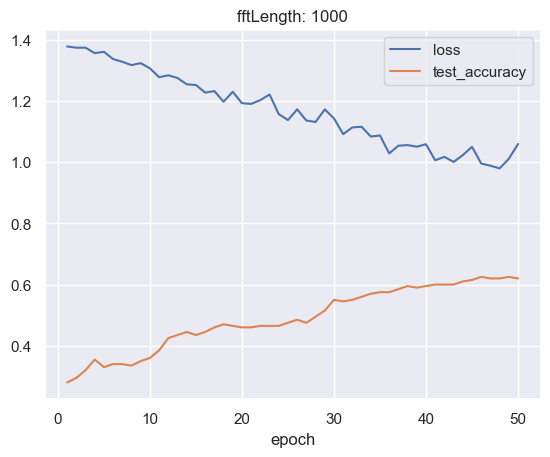

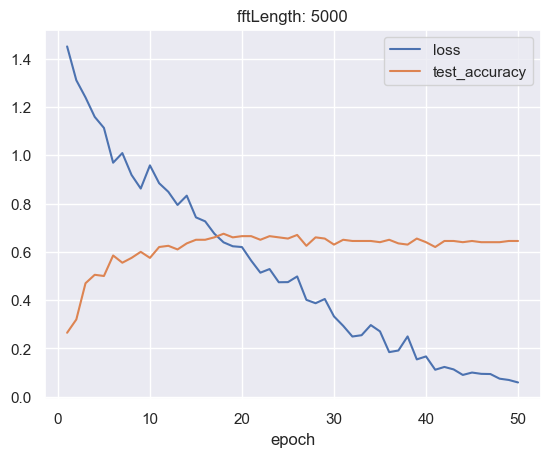

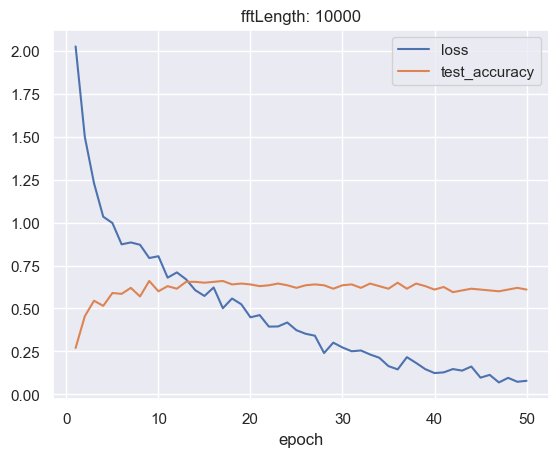

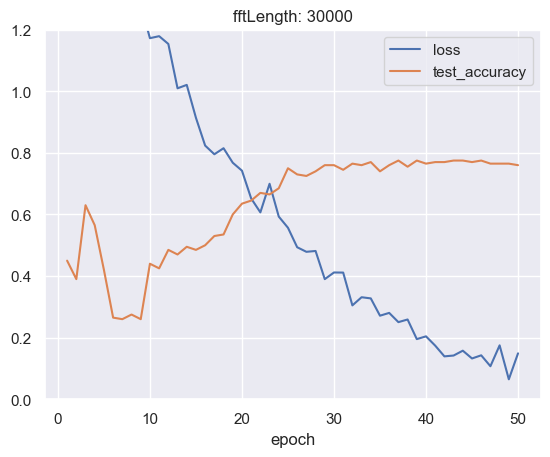

In [109]:
print("Fixing some values : learningRate: 0.001, maxEpoch: 50, dataset_length: 1000")
loss = [1.378232479095459,1.3741925954818726,1.3742882013320923,1.3563551902770996,1.36077082157135,1.3368942737579346,1.3281503915786743,1.3172894716262817,1.323609709739685,1.3065961599349976,1.277806282043457,1.2838475704193115,1.2750600576400757,1.2543988227844238,1.2521852254867554,1.2273756265640259,1.2323360443115234,1.1976474523544312,1.2300885915756226,1.192687749862671,1.190543532371521,1.2028924226760864,1.221186637878418,1.1570675373077393,1.137753963470459,1.1727138757705688,1.1359529495239258,1.13140070438385,1.1724369525909424,1.142988920211792,1.0917837619781494,1.1135107278823853,1.11575448513031,1.0837485790252686,1.0872926712036133,1.028605341911316,1.0538452863693237,1.055773138999939,1.0506539344787598,1.0586059093475342,1.0061299800872803,1.0173449516296387,1.0008978843688965,1.023085355758667,1.050115704536438,0.9955650568008423,0.9884156584739685,0.9797443747520447,1.0111171007156372,1.059191346168518]
accuracy = [0.28,0.295,0.32,0.355,0.33,0.34,0.34,0.335,0.35,0.36,0.385,0.425,0.435,0.445,0.435,0.445,0.46,0.47,0.465,0.46,0.46,0.465,0.465,0.465,0.475,0.485,0.475,0.495,0.515,0.55,0.545,0.55,0.56,0.57,0.575,0.575,0.585,0.595,0.59,0.595,0.6,0.6,0.6,0.61,0.615,0.625,0.62,0.62,0.625,0.62]
plot("fftLength: 1000", loss, accuracy)

loss = [1.4503898620605469,1.3105716705322266,1.2392921447753906,1.1587821245193481,1.113165259361267,0.9690585136413574,1.0089058876037598,0.9185359477996826,0.8620460033416748,0.9580739140510559,0.8841140866279602,0.8485391139984131,0.7940545082092285,0.8326016068458557,0.7427485585212708,0.7263000011444092,0.6752510070800781,0.6394103169441223,0.6231377720832825,0.6198451519012451,0.5637595057487488,0.513727605342865,0.5287126898765564,0.47417744994163513,0.4746539294719696,0.4981626272201538,0.40130507946014404,0.3872120678424835,0.4048129916191101,0.3327113091945648,0.2937435507774353,0.24944615364074707,0.25483962893486023,0.29678523540496826,0.27064910531044006,0.1847945749759674,0.19152973592281342,0.24985074996948242,0.15474148094654083,0.16701284050941467,0.11190538853406906,0.12345296144485474,0.11327517032623291,0.09038650244474411,0.1002524122595787,0.09491217881441116,0.0940767377614975,0.0748327448964119,0.06956028938293457,0.05926564708352089]
accuracy = [0.265,0.32,0.47,0.505,0.5,0.585,0.555,0.575,0.6,0.575,0.62,0.625,0.61,0.635,0.65,0.65,0.66,0.675,0.66,0.665,0.665,0.65,0.665,0.66,0.655,0.67,0.625,0.66,0.655,0.63,0.65,0.645,0.645,0.645,0.64,0.65,0.635,0.63,0.655,0.64,0.62,0.645,0.645,0.64,0.645,0.64,0.64,0.64,0.645,0.645]
plot("fftLength: 5000", loss, accuracy)

loss = [2.025805711746216,1.49932062625885,1.2292615175247192,1.034317135810852,0.9975247383117676,0.8733822703361511,0.8844341039657593,0.8709646463394165,0.7936298847198486,0.8041642904281616,0.6792932748794556,0.7099136114120483,0.6698719263076782,0.6063609719276428,0.5728145837783813,0.6220350861549377,0.5015223622322083,0.5579477548599243,0.5245182514190674,0.44848936796188354,0.4613608717918396,0.3942430019378662,0.39519578218460083,0.41825827956199646,0.3732655346393585,0.3525177538394928,0.34134382009506226,0.24037738144397736,0.30084216594696045,0.27279964089393616,0.25074246525764465,0.2552534341812134,0.23202107846736908,0.2129725068807602,0.16416820883750916,0.14521394670009613,0.21634875237941742,0.1828002631664276,0.14655515551567078,0.1237960085272789,0.12774737179279327,0.1471071094274521,0.13795088231563568,0.16188739240169525,0.09700807183980942,0.1132042333483696,0.06911489367485046,0.09591756761074066,0.07303663343191147,0.0786830484867096]
accuracy = [0.27,0.455,0.545,0.515,0.59,0.585,0.62,0.57,0.66,0.6,0.63,0.615,0.655,0.655,0.65,0.655,0.66,0.64,0.645,0.64,0.63,0.635,0.645,0.635,0.62,0.635,0.64,0.635,0.615,0.635,0.64,0.62,0.645,0.63,0.615,0.65,0.615,0.645,0.63,0.61,0.625,0.595,0.605,0.615,0.61,0.605,0.6,0.61,0.62,0.61]
plot("fftLength: 10000", loss, accuracy)

loss = [6.625688552856445,1.677172064781189,5.50569486618042,2.309861898422241,1.8157682418823242,1.3700835704803467,1.7207051515579224,1.3855005502700806,1.2805547714233398,1.1723263263702393,1.178817868232727,1.153581142425537,1.0095735788345337,1.020641565322876,0.9137303829193115,0.8235979080200195,0.7954480648040771,0.815018892288208,0.7679347991943359,0.7421505451202393,0.6519943475723267,0.606762707233429,0.6995878219604492,0.5930888652801514,0.5567671656608582,0.49356380105018616,0.4787144958972931,0.4814065098762512,0.38999325037002563,0.4115995168685913,0.41124144196510315,0.3047521412372589,0.3312433958053589,0.3274286985397339,0.2712783217430115,0.280369371175766,0.25038233399391174,0.2589646577835083,0.19525974988937378,0.2042403221130371,0.17405341565608978,0.13925175368785858,0.1419541984796524,0.15767501294612885,0.1324101984500885,0.14262662827968597,0.10724586248397827,0.174998477101326,0.06475736200809479,0.1490291953086853]
accuracy = [0.45,0.39,0.63,0.565,0.42,0.265,0.26,0.275,0.26,0.44,0.425,0.485,0.47,0.495,0.485,0.5,0.53,0.535,0.6,0.635,0.645,0.67,0.665,0.685,0.75,0.73,0.725,0.74,0.76,0.76,0.745,0.765,0.76,0.77,0.74,0.76,0.775,0.755,0.775,0.765,0.77,0.77,0.775,0.775,0.77,0.775,0.765,0.765,0.765,0.76]
plot("fftLength: 30000", loss, accuracy, 0, 1.2)

ixing some values : learningRate: 0.001, maxEpoch: 50, fftLength: 5000


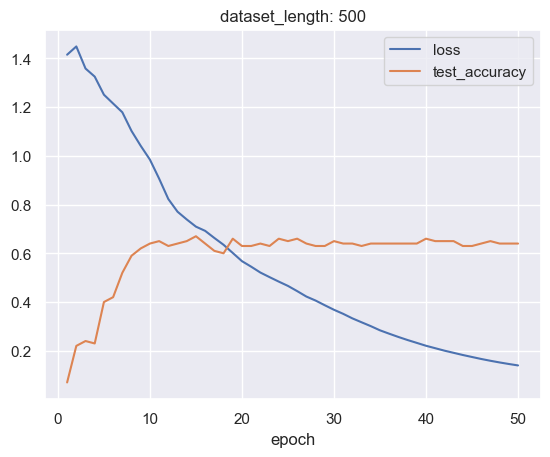

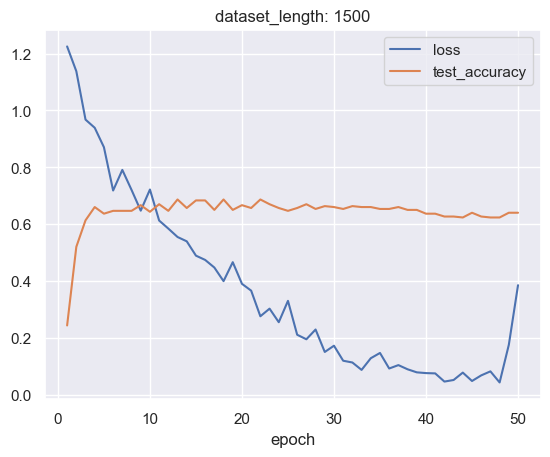

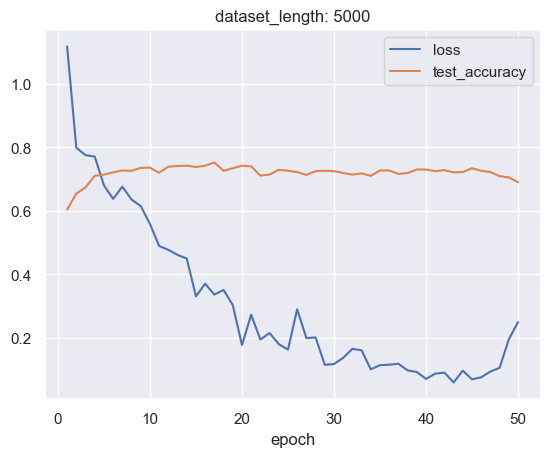

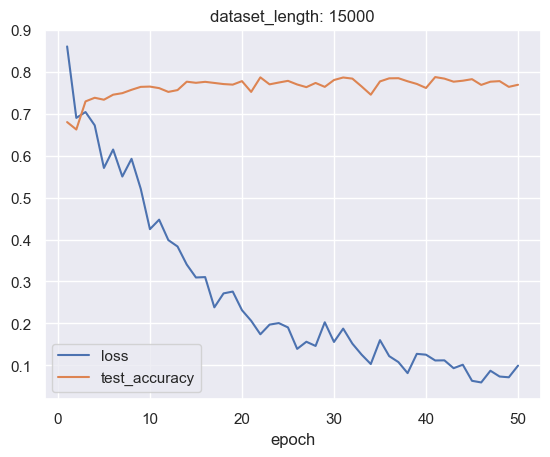

In [110]:
print("ixing some values : learningRate: 0.001, maxEpoch: 50, fftLength: 5000")

loss = [1.4150007963180542,1.448879599571228,1.3582490682601929,1.3250447511672974,1.2508296966552734,1.214565396308899,1.17873215675354,1.102023959159851,1.0409331321716309,0.9843569397926331,0.9062859416007996,0.8225734233856201,0.7705988883972168,0.7388894557952881,0.7093604207038879,0.6920906901359558,0.6628944873809814,0.6349306702613831,0.6014139652252197,0.5677473545074463,0.545112133026123,0.5210351347923279,0.5021841526031494,0.48382729291915894,0.4661455452442169,0.44482558965682983,0.42249301075935364,0.4061107933521271,0.38683587312698364,0.3682168126106262,0.35157763957977295,0.3329525887966156,0.3168959319591522,0.3010547161102295,0.28388968110084534,0.27003395557403564,0.2566545009613037,0.24405986070632935,0.23235341906547546,0.22054332494735718,0.21054445207118988,0.20047912001609802,0.19157782196998596,0.1826632171869278,0.17446905374526978,0.1663413792848587,0.15894868969917297,0.15207044780254364,0.14573729038238525,0.13986939191818237]
accuracy = [0.07,0.22,0.24,0.23,0.4,0.42,0.52,0.59,0.62,0.64,0.65,0.63,0.64,0.65,0.67,0.64,0.61,0.6,0.66,0.63,0.63,0.64,0.63,0.66,0.65,0.66,0.64,0.63,0.63,0.65,0.64,0.64,0.63,0.64,0.64,0.64,0.64,0.64,0.64,0.66,0.65,0.65,0.65,0.63,0.63,0.64,0.65,0.64,0.64,0.64]
plot("dataset_length: 500", loss, accuracy)

loss = [1.225204348564148,1.1379973888397217,0.9677284955978394,0.9389879107475281,0.8705946207046509,0.7182455658912659,0.790730357170105,0.7204050421714783,0.6473108530044556,0.7217168211936951,0.6125702261924744,0.5841668248176575,0.5546251535415649,0.5393794178962708,0.4889812469482422,0.4739464819431305,0.44715550541877747,0.3992971181869507,0.4659910500049591,0.38985100388526917,0.3658289313316345,0.275674432516098,0.30246904492378235,0.25477153062820435,0.32988059520721436,0.21061256527900696,0.19468191266059875,0.2290545403957367,0.15003319084644318,0.17200441658496857,0.11917424201965332,0.11295905709266663,0.08692023158073425,0.1280132681131363,0.146553635597229,0.09183190017938614,0.10376108437776566,0.08904685080051422,0.0783037543296814,0.07566694170236588,0.07462502270936966,0.04581134766340256,0.051378749310970306,0.07739032804965973,0.04783902317285538,0.06761009246110916,0.08176852017641068,0.04274619743227959,0.17516744136810303,0.3850055932998657]
accuracy = [0.24333333333333335,0.52,0.6133333333333333,0.66,0.6366666666666667,0.6466666666666666,0.6466666666666666,0.6466666666666666,0.6666666666666666,0.6433333333333333,0.67,0.6466666666666666,0.6866666666666666,0.6566666666666666,0.6833333333333333,0.6833333333333333,0.65,0.6866666666666666,0.65,0.6666666666666666,0.6566666666666666,0.6866666666666666,0.67,0.6566666666666666,0.6466666666666666,0.6566666666666666,0.67,0.6533333333333333,0.6633333333333333,0.66,0.6533333333333333,0.6633333333333333,0.66,0.66,0.6533333333333333,0.6533333333333333,0.66,0.65,0.65,0.6366666666666667,0.6366666666666667,0.6266666666666667,0.6266666666666667,0.6233333333333333,0.64,0.6266666666666667,0.6233333333333333,0.6233333333333333,0.64,0.64]
plot("dataset_length: 1500", loss, accuracy)

loss = [1.1174712181091309,0.7986711263656616,0.7751681804656982,0.7706395983695984,0.680203378200531,0.637665867805481,0.675891101360321,0.6354383230209351,0.6150462627410889,0.5586584210395813,0.4891802668571472,0.4770427644252777,0.4611966013908386,0.4496963322162628,0.33050739765167236,0.3705543577671051,0.3361169397830963,0.3509174585342407,0.30342891812324524,0.1773250699043274,0.27267101407051086,0.19474689662456512,0.21502232551574707,0.18033979833126068,0.16299502551555634,0.28987741470336914,0.19926901161670685,0.20140710473060608,0.11521527171134949,0.11739885807037354,0.13707759976387024,0.16543680429458618,0.1606447398662567,0.10071227699518204,0.1140444278717041,0.11535464972257614,0.11839083582162857,0.09745672345161438,0.09257669001817703,0.07068943232297897,0.08716259151697159,0.09061123430728912,0.059572216123342514,0.09678459167480469,0.06923074275255203,0.07588711380958557,0.09376665949821472,0.10574477165937424,0.19535882771015167,0.24958616495132446]
accuracy = [0.604,0.654,0.674,0.71,0.714,0.721,0.727,0.726,0.735,0.736,0.72,0.739,0.741,0.742,0.738,0.742,0.752,0.726,0.734,0.742,0.74,0.711,0.714,0.729,0.726,0.722,0.713,0.725,0.726,0.725,0.719,0.714,0.718,0.71,0.727,0.727,0.716,0.719,0.73,0.73,0.725,0.728,0.721,0.722,0.734,0.726,0.722,0.709,0.705,0.69]
plot("dataset_length: 5000", loss, accuracy)

loss = [0.8603696823120117,0.6900326013565063,0.7039545774459839,0.6722202301025391,0.5706794261932373,0.6145685911178589,0.5501969456672668,0.5923910737037659,0.5209993124008179,0.42468658089637756,0.44733476638793945,0.3986046612262726,0.38335439562797546,0.3403564691543579,0.3094436824321747,0.31039130687713623,0.2382795363664627,0.27153903245925903,0.2758788764476776,0.23152032494544983,0.20621931552886963,0.17399731278419495,0.19704240560531616,0.20075148344039917,0.19039416313171387,0.13919666409492493,0.15622322261333466,0.1462257206439972,0.20265521109104156,0.15574520826339722,0.18753856420516968,0.15168729424476624,0.12554560601711273,0.10305287688970566,0.16005179286003113,0.12194012850522995,0.1077556386590004,0.08138959854841232,0.1273588240146637,0.12536323070526123,0.1115703135728836,0.11188782751560211,0.09317325055599213,0.10143578052520752,0.06307291984558105,0.05917239934206009,0.08711645752191544,0.07328323274850845,0.0714755728840828,0.09922510385513306]
accuracy = [0.68,0.6623333333333333,0.7293333333333333,0.738,0.7333333333333333,0.7453333333333333,0.749,0.757,0.764,0.7646666666666667,0.761,0.752,0.7563333333333333,0.7763333333333333,0.7736666666666666,0.776,0.7733333333333333,0.7706666666666667,0.7693333333333333,0.7776666666666666,0.752,0.7866666666666666,0.77,0.7743333333333333,0.7783333333333333,0.7696666666666667,0.7633333333333333,0.7733333333333333,0.764,0.7803333333333333,0.7863333333333333,0.7836666666666666,0.765,0.7453333333333333,0.777,0.7843333333333333,0.7846666666666666,0.7773333333333333,0.771,0.7613333333333333,0.7873333333333333,0.7836666666666666,0.7763333333333333,0.7786666666666666,0.7823333333333333,0.7686666666666667,0.7763333333333333,0.7776666666666666,0.764,0.769]
plot("dataset_length: 15000", loss, accuracy)

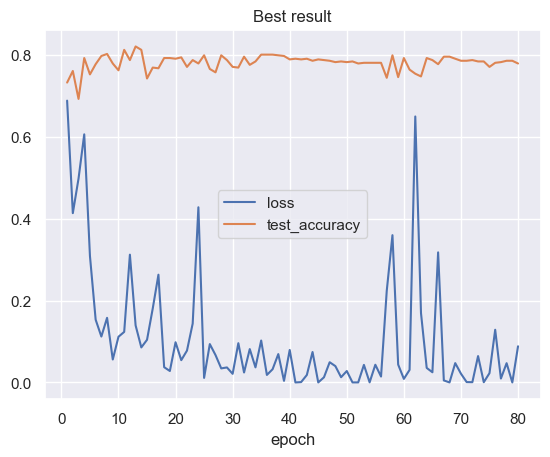

In [111]:
#Training data : lr: 0.001, maxEpoch: 80, fftLength: 30000, dataset_length: 3000
loss = [0.783134937286377,0.5641193389892578,0.5226346850395203,0.5501182079315186,0.4225170612335205,0.3295079469680786,0.029554059728980064,0.16419048607349396,0.4479197561740875,0.21101543307304382,0.19477352499961853,0.038647133857011795,0.1303662657737732,0.2138470858335495,5.6512566516175866e-05,0.007266823202371597,0.1290813386440277,0.06777457892894745,0.0016535440227016807,0.002561903093010187,0.0010429427493363619,9.536715879221447e-07,0.3364345133304596,0.03951774165034294,0.04008886590600014,0.4087931513786316,0.001441325293853879,1.0003687143325806,0.0319342203438282,0.004120380152016878]
accuracy = [0.731,0.728,0.757,0.74,0.763,0.78,0.773,0.763,0.767,0.781,0.764,0.781,0.778,0.77,0.76,0.785,0.774,0.788,0.786,0.79,0.79,0.788,0.76,0.768,0.791,0.743,0.783,0.738,0.779,0.787]
plot("Best result", loss, accuracy)

In [112]:
#clear memory
model = None
criterion = None
optimizer = None
train_dataset = None
train_loader = None

inputs_train, inputs_test, labels_train, labels_test = train_test_split(spectrograms, labels, test_size = 0.2, random_state=145)
inputs_train = torch.stack(inputs_train).float()
labels_train = torch.tensor(labels_train, dtype=torch.int32)
inputs_test = torch.stack(inputs_test).float()
labels_test = torch.tensor(labels_test, dtype=torch.int32)

In [113]:
#try gaussian misxture
gm = GaussianMixture(n_components=4, covariance_type='full', init_params='kmeans')
gm.fit(inputs_train)

GaussianMixture(n_components=4)

In [114]:
def plot_gmm_confusion_matrix(predictions, true_labels, class_names):
    cm = confusion_matrix(true_labels, predictions)
    plot_confusion_matrix_from_cm(cm, class_names)

def plot_confusion_matrix_from_cm(cm, class_names):
    sns.set()
    plt.figure(figsize=(len(class_names), len(class_names)))
    ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix')
    plt.show()

Accuracy of the network on test inputs: 24.5%


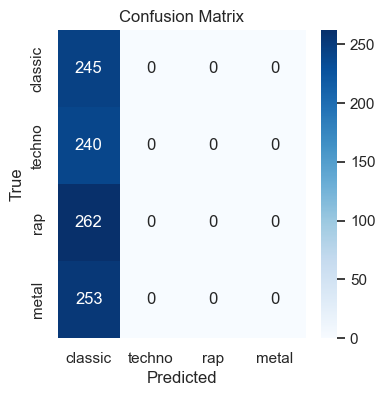

In [115]:
pred = gm.predict(inputs_test)
pred = torch.tensor(pred, dtype=torch.int32)
correct = (pred == labels_test).sum().item()
accuracy = correct / labels_test.size(0)
print(f'Accuracy of the network on test inputs: {accuracy * 100}%')
plot_gmm_confusion_matrix(pred, labels_test.to('cpu').numpy(), themes)